In [19]:
import pandas as pd
import numpy as np
import os
import warnings

from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import mean_squared_log_error
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

pd.set_option("max_columns", 500)

In [5]:
def make_is_bad_zero(Xy_subset, min_interval=48, summer_start=3000, summer_end=7500):
    """Helper routine for 'find_bad_zeros'.
    
    This operates upon a single dataframe produced by 'groupby'. We expect an 
    additional column 'meter_id' which is a duplicate of 'meter' because groupby 
    eliminates the original one."""
    meter = Xy_subset.meter_id.iloc[0]
    is_zero = Xy_subset.meter_reading == 0
    if meter == 0:
        # Electrical meters should never be zero. Keep all zero-readings in this table so that
        # they will all be dropped in the train set.
        return is_zero

    transitions = (is_zero != is_zero.shift(1))
    all_sequence_ids = transitions.cumsum()
    ids = all_sequence_ids[is_zero].rename("ids")
    if meter in [2, 3]:
        # It's normal for steam and hotwater to be turned off during the summer
        keep = set(ids[(Xy_subset.timestamp < summer_start) |
                       (Xy_subset.timestamp > summer_end)].unique())
        is_bad = ids.isin(keep) & (ids.map(ids.value_counts()) >= min_interval)
    elif meter == 1:
        time_ids = ids.to_frame().join(Xy_subset.timestamp).set_index("timestamp").ids
        is_bad = ids.map(ids.value_counts()) >= min_interval

        # Cold water may be turned off during the winter
        jan_id = time_ids.get(0, False)
        dec_id = time_ids.get(8283, False)
        if (jan_id and dec_id and jan_id == time_ids.get(500, False) and
                dec_id == time_ids.get(8783, False)):
            is_bad = is_bad & (~(ids.isin(set([jan_id, dec_id]))))
    else:
        raise Exception("Unexpected meter type:")

    result = is_zero.copy()
    result.update(is_bad)
    return result

def find_bad_zeros(X, y):
    """Returns an Index object containing only the rows which should be deleted."""
    Xy = X.assign(meter_reading=y, meter_id=X.meter)
    is_bad_zero = Xy.groupby(["building_id", "meter"]).apply(make_is_bad_zero)
    return is_bad_zero[is_bad_zero].index.droplevel([0, 1])

In [6]:
def find_bad_sitezero(X):
    """Returns indices of bad rows from the early days of Site 0 (UCF)."""
    return X[(X.timestamp < 3378) & (X.site_id == 0) & (X.meter == 0)].index

In [7]:
def find_bad_building1099(X, y):
    """Returns indices of bad rows (with absurdly high readings) from building 1099."""
    return X[(X.building_id == 1099) & (X.meter == 2) & (y > 3e4)].index

In [8]:
def find_bad_rows(X, y):
    return find_bad_zeros(X, y).union(find_bad_sitezero(X)).union(find_bad_building1099(X, y))

In [29]:
def input_file(file):
    path = 'train_opt'
    return path

def compress_dataframe(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    

    return df

def read_train():
    df = pd.read_csv("train.csv")
    df.timestamp=pd.to_datetime(df.timestamp)
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    return compress_dataframe(df)

def read_building_metadata():
    return compress_dataframe(pd.read_csv("building_metadata.csv").fillna(-1)).set_index("building_id")

site_GMT_offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

def read_weather_train(fix_timestamps=True, interpolate_na=True, add_na_indicators=True):
    df = pd.read_csv("weather_train.csv")
    df.timestamp=pd.to_datetime(df.timestamp)
    
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    if fix_timestamps:
        GMT_offset_map = {site: offset for site, offset in enumerate(site_GMT_offsets)}
        df.timestamp = df.timestamp + df.site_id.map(GMT_offset_map)
    if interpolate_na:
        site_dfs = []
        for site_id in df.site_id.unique():
            # Make sure that we include all possible hours so that we can interpolate evenly
            site_df = df[df.site_id == site_id].set_index("timestamp").reindex(range(8784))
            site_df.site_id = site_id
            for col in [c for c in site_df.columns if c != "site_id"]:
                if add_na_indicators: site_df["had_{}".format(col)] = ~site_df[col].isna()
                site_df[col] = site_df[col].interpolate(limit_direction='both', method='linear')
                # Some sites are completely missing some columns, so use this fallback
                site_df[col] = site_df[col].fillna(df[col].median())
            site_dfs.append(site_df)
        df = pd.concat(site_dfs).reset_index()  # make timestamp back into a regular column
    elif add_na_indicators:
        for col in df.columns:
            if df[col].isna().any(): df["had_{}".format(col)] = ~df[col].isna()
    return compress_dataframe(df).set_index(["site_id", "timestamp"])

def combined_train_data(fix_timestamps=True, interpolate_na=True, add_na_indicators=True):
    Xy = (read_train().join(read_building_metadata(), on="building_id").join(
        read_weather_train(fix_timestamps, interpolate_na, add_na_indicators),
        on=["site_id", "timestamp"]))
    return Xy.drop(columns=["meter_reading"]), Xy.meter_reading

def _add_time_features(X):
    return X.assign(tm_day_of_week=((X.timestamp // 24) % 7), tm_hour_of_day=(X.timestamp % 24))

class CatSplitRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model, col):
        self.model = model
        self.col = col

    def fit(self, X, y):
        self.fitted = {}
        importances = []
        for val in X[self.col].unique():
            X1 = X[X[self.col] == val].drop(columns=[self.col])
            self.fitted[val] = clone(self.model).fit(X1, y.reindex_like(X1))
            importances.append(self.fitted[val].feature_importances_)
            del X1
        fi = np.average(importances, axis=0)
        col_index = list(X.columns).index(self.col)
        self.feature_importances_ = [*fi[:col_index], 0, *fi[col_index:]]
        return self

    def predict(self, X):
        result = np.zeros(len(X))
        for val in X[self.col].unique():
            ix = np.nonzero((X[self.col] == val).to_numpy())
            predictions = self.fitted[val].predict(X.iloc[ix].drop(columns=[self.col]))
            result[ix] = predictions
        return result

categorical_columns = [
    "building_id", "meter", "site_id", "primary_use", "had_air_temperature", "had_cloud_coverage",
    "had_dew_temperature", "had_precip_depth_1_hr", "had_sea_level_pressure", "had_wind_direction",
    "had_wind_speed", "tm_day_of_week", "tm_hour_of_day"
]

class LGBMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, categorical_feature=None, **params):
        self.model = LGBMRegressor(**params)
        self.categorical_feature = categorical_feature

    def fit(self, X, y):
        with warnings.catch_warnings():
            cats = None if self.categorical_feature is None else list(
                X.columns.intersection(self.categorical_feature))
            warnings.filterwarnings("ignore",
                                    "categorical_feature in Dataset is overridden".lower())
            self.model.fit(X, y, **({} if cats is None else {"categorical_feature": cats}))
            self.feature_importances_ = self.model.feature_importances_
            return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return {**self.model.get_params(deep), "categorical_feature": self.categorical_feature}

    def set_params(self, **params):
        ctf = params.pop("categorical_feature", None)
        if ctf is not None: self.categorical_feature = ctf
        self.model.set_params(params)

In [123]:
X, y = combined_train_data()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.52 MB
Decreased by 71.9%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 10.59 MB
Memory usage after optimization is: 4.16 MB
Decreased by 60.8%


In [66]:
X['air_temperature'].value_counts()

 24.406250    391772
 25.593750    377348
 18.906250    368815
 22.796875    357658
 15.000000    357197
               ...  
-8.351562          1
-21.656250         1
 9.632812          1
 13.851562         1
-1.950195          1
Name: air_temperature, Length: 846, dtype: int64

In [124]:

bad_rows = find_bad_rows(X, y)

In [125]:
bad_rows

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,        7,        8,        9,
            ...
            20215900, 20216003, 20216009, 20216012, 20216014, 20216016,
            20216018, 20216044, 20216046, 20216097],
           dtype='int64', length=1182575)

In [126]:
X = X.drop(index=bad_rows)
y = y.reindex_like(X)



In [129]:
# Additional preprocessing
X = compress_dataframe(_add_time_features(X))
X = X.drop(columns="timestamp")  # Raw timestamp doesn't help when prediction
y = np.log1p(y)



Memory usage of dataframe is 998.35 MB
Memory usage after optimization is: 998.35 MB
Decreased by 0.0%


In [53]:
import lightgbm as lgb

In [55]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
train_data = lgb.Dataset(x, label=y, categorical_feature=categorical_columns)
test_data = lgb.Dataset(x_test, label=y_test)

In [56]:
params={}
params['learning_rate'] = 0.01

params['objective'] = 'regression'


params['max_depth'] = 10
params['verbosity'] = 10

In [58]:
import math

def rmsle(y_true, y_pred):
#     print(type(y_true),type(y_pred))
    y_pred=y_pred.get_label()
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log(1+y_pred) - np.log(1+y_true), 2))), False

In [64]:
model = lgb.train(params,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                          feval=rmsle,
                       early_stopping_rounds=100)

SyntaxError: keyword argument repeated (<ipython-input-64-a4fd70e9a4dc>, line 6)

In [ ]:
y_pred=model.predict(X)

In [61]:
import matplotlib.pyplot as plt

<BarContainer object of 23 artists>

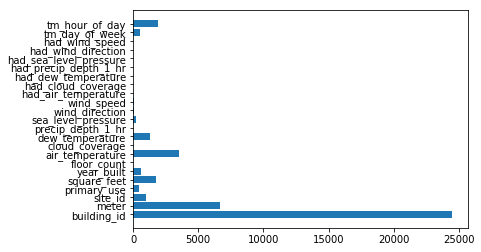

In [62]:
plt.barh(model.feature_name(),model.feature_importance())

In [36]:
model = CatSplitRegressor(
    LGBMWrapper(random_state=0, n_jobs=-1, categorical_feature=categorical_columns), "meter")

model.fit(X, y)

CatSplitRegressor(col='meter',
                  model=LGBMWrapper(boosting_type='gbdt',
                                    categorical_feature=['building_id', 'meter',
                                                         'site_id',
                                                         'primary_use',
                                                         'had_air_temperature',
                                                         'had_cloud_coverage',
                                                         'had_dew_temperature',
                                                         'had_precip_depth_1_hr',
                                                         'had_sea_level_pressure',
                                                         'had_wind_direction',
                                                         'had_wind_speed',
                                                         'tm_day_of_week',
                                                         

In [43]:
def read_test():
    df = pd.read_csv("test.csv", parse_dates=["timestamp"])
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    return compress_dataframe(df).set_index("row_id")

def read_weather_test(fix_timestamps=True, interpolate_na=True, add_na_indicators=True):
    df = pd.read_csv("weather_test.csv", parse_dates=["timestamp"])
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    if fix_timestamps:
        GMT_offset_map = {site: offset for site, offset in enumerate(site_GMT_offsets)}
        df.timestamp = df.timestamp + df.site_id.map(GMT_offset_map)
    if interpolate_na:
        site_dfs = []
        for site_id in df.site_id.unique():
            # Make sure that we include all possible hours so that we can interpolate evenly
            site_df = df[df.site_id == site_id].set_index("timestamp").reindex(range(8784, 26304))
            site_df.site_id = site_id
            for col in [c for c in site_df.columns if c != "site_id"]:
                if add_na_indicators: site_df["had_{}".format(col)] = ~site_df[col].isna()
                site_df[col] = site_df[col].interpolate(limit_direction='both', method='linear')
                # Some sites are completely missing some columns, so use this fallback
                site_df[col] = site_df[col].fillna(df[col].median())
            site_dfs.append(site_df)
        df = pd.concat(site_dfs).reset_index()  # make timestamp back into a regular column
    elif add_na_indicators:
        for col in df.columns:
            if df[col].isna().any(): df["had_{}".format(col)] = ~df[col].isna()
    return compress_dataframe(df).set_index(["site_id", "timestamp"])

def combined_test_data(fix_timestamps=True, interpolate_na=True, add_na_indicators=True):
    X = compress_dataframe(read_test().join(read_building_metadata(), on="building_id").join(
        read_weather_test(fix_timestamps, interpolate_na, add_na_indicators),
        on=["site_id", "timestamp"]))
    return X

In [44]:
X1 = combined_test_data()
X1 = compress_dataframe(_add_time_features(X1))
X1 = X1.drop(columns="timestamp")  # Raw timestamp doesn't help when prediction



Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 357.89 MB
Decreased by 71.9%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 21.12 MB
Memory usage after optimization is: 8.29 MB
Decreased by 60.8%
Memory usage of dataframe is 2028.06 MB
Memory usage after optimization is: 2028.06 MB
Decreased by 0.0%
Memory usage of dataframe is 2187.13 MB
Memory usage after optimization is: 2187.13 MB
Decreased by 0.0%


In [45]:
predictions = pd.DataFrame({
    "row_id": X1.index,
    "meter_reading": np.clip(np.expm1(model.predict(X1)), 0, None)
})

In [46]:
predictions.head()

,meter_reading,row_id
0,179.147564,0
1,76.726490,1
2,7.128338,2
3,305.654408,3
4,1426.932184,4


In [51]:
predictions.to_csv('submissions.csv',index=False)

In [52]:
pd.read_csv('submissions.csv',nrows=500).head()

,meter_reading,row_id
0,179.147564,0
1,76.726490,1
2,7.128338,2
3,305.654408,3
4,1426.932184,4


In [67]:
##Lag features

In [133]:
def supervised_conversion(df,timesteps):
    df_out=df.drop(columns=['primary_use', 'square_feet',
       'year_built', 'floor_count',  'cloud_coverage',
        'sea_level_pressure','wind_direction',
      'wind_speed', 'had_air_temperature',
       'had_cloud_coverage', 'had_dew_temperature', 'had_precip_depth_1_hr',
       'had_sea_level_pressure', 'had_wind_direction', 'had_wind_speed',
       'tm_day_of_week', 'tm_hour_of_day','site_id'])
    
    temp=df_out.iloc[0:0]
    
    temp=temp.rename(columns={'building_id':'b','meter':'m1',
                              'air_temperature':'a1','dew_temperature':'d1', 'precip_depth_1_hr':'p1'})
    
    for i in (range(1,timesteps)):
        df1=df_out.shift(i)
        
        df1.fillna(-1,inplace=True)
        df1.meter=df1.meter.astype(int)
        df1.building_id=df1.building_id.astype(int)
        df1=df1.rename(columns={'building_id':'building_id_t-'+str(i),'meter':'meter_t-'+str(i),
                                'air_temperature':'air_temperature_t-'+str(i),'dew_temperature':'dew_temperature_t-'+str(i),
                                'precip_depth_1_hr':'precip_depth_1_hr_t-'+str(i)
                               })
        temp=pd.concat([temp,df1],axis=1)
       
        if i ==1:
            temp.drop(columns=['b','m1','a1','d1','p1'],inplace=True)
               
    df=pd.concat([df,temp],axis=1)
    bef=df.shape
    
    for i in range(1,timesteps):
        df=df[df['meter'] == df['meter_t-'+str(i)]]
        df=df[df['building_id']   ==  df['building_id_t-'+str(i)]]
        df.drop(columns=['meter_t-'+str(i),'building_id_t-'+str(i)],inplace=True)

    
    aft=df.shape
    
    
    print('rows removed: ',bef[0]-aft[0])
    
    
    return df
    
    
    

In [151]:
X1=X
y1=y

In [152]:
X1.sort_values(by=['building_id','meter'],inplace=True)

In [153]:

X1=supervised_conversion(X1,10)


rows removed:  21412


In [154]:
y1=y

In [155]:
y1=y1.reindex_like(X1)

In [156]:
y1

7597833     5.535549
7600174          NaN
7602517     5.567344
7604859     5.516525
7607202     5.538239
              ...   
20206636         NaN
20209002         NaN
20211367    1.398717
20213733    1.417066
20216099    1.348073
Name: meter_reading, Length: 19012113, dtype: float32

In [162]:
X1.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,had_air_temperature,had_cloud_coverage,had_dew_temperature,had_precip_depth_1_hr,had_sea_level_pressure,had_wind_direction,had_wind_speed,tm_day_of_week,tm_hour_of_day,air_temperature_t-1,dew_temperature_t-1,precip_depth_1_hr_t-1,air_temperature_t-2,dew_temperature_t-2,precip_depth_1_hr_t-2,air_temperature_t-3,dew_temperature_t-3,precip_depth_1_hr_t-3,air_temperature_t-4,dew_temperature_t-4,precip_depth_1_hr_t-4,air_temperature_t-5,dew_temperature_t-5,precip_depth_1_hr_t-5,air_temperature_t-6,dew_temperature_t-6,precip_depth_1_hr_t-6,air_temperature_t-7,dew_temperature_t-7,precip_depth_1_hr_t-7,air_temperature_t-8,dew_temperature_t-8,precip_depth_1_hr_t-8,air_temperature_t-9,dew_temperature_t-9,precip_depth_1_hr_t-9
7597833,0,0,0,Education,7432,2008.0,-1.0,22.796875,7.000000,21.093750,0.0,1015.0,0.0,0.000000,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,22.796875,21.09375,5.0,23.906250,20.59375,0.0,23.906250,20.59375,0.0,23.906250,20.59375,0.0,25.000000,20.59375,0.0,25.59375,20.59375,0.0,25.59375,20.59375,0.0,25.59375,20.59375,0.0,27.203125,19.40625,0.0
7600174,0,0,0,Education,7432,2008.0,-1.0,22.796875,7.000000,21.093750,0.0,1015.0,0.0,0.000000,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,22.796875,21.09375,0.0,22.796875,21.09375,5.0,23.906250,20.59375,0.0,23.906250,20.59375,0.0,23.906250,20.59375,0.0,25.00000,20.59375,0.0,25.59375,20.59375,0.0,25.59375,20.59375,0.0,25.593750,20.59375,0.0
7602517,0,0,0,Education,7432,2008.0,-1.0,22.796875,7.000000,21.093750,0.0,1015.0,0.0,0.000000,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,22.796875,21.09375,0.0,22.796875,21.09375,0.0,22.796875,21.09375,5.0,23.906250,20.59375,0.0,23.906250,20.59375,0.0,23.90625,20.59375,0.0,25.00000,20.59375,0.0,25.59375,20.59375,0.0,25.593750,20.59375,0.0
7604859,0,0,0,Education,7432,2008.0,-1.0,22.203125,6.332031,21.093750,0.0,1016.0,0.0,0.000000,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,22.796875,21.09375,0.0,22.796875,21.09375,0.0,22.796875,21.09375,0.0,22.796875,21.09375,5.0,23.906250,20.59375,0.0,23.90625,20.59375,0.0,23.90625,20.59375,0.0,25.00000,20.59375,0.0,25.593750,20.59375,0.0
7607202,0,0,0,Education,7432,2008.0,-1.0,25.000000,6.000000,21.703125,0.0,1017.0,260.0,2.599609,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,22.203125,21.09375,0.0,22.796875,21.09375,0.0,22.796875,21.09375,0.0,22.796875,21.09375,0.0,22.796875,21.09375,5.0,23.90625,20.59375,0.0,23.90625,20.59375,0.0,23.90625,20.59375,0.0,25.000000,20.59375,0.0


In [157]:
x, x_test, y, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [164]:
train_data = lgb.Dataset(x, label=y, categorical_feature=categorical_columns)
test_data = lgb.Dataset(x_test, label=y_test)

In [165]:
params={}
params['learning_rate'] = 0.01

params['objective'] = 'regression'


params['max_depth'] = 10
params['verbosity'] = 10

In [166]:
import math

def rmsle(y_true, y_pred):
#     print(type(y_true),type(y_pred))
    y_pred=y_pred.get_label()
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log(1+y_pred) - np.log(1+y_true), 2))), False

In [167]:
model = lgb.train(params,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                          feval=rmsle,
                       early_stopping_rounds=100)

[1]	valid_0's l2: 6.0665	valid_0's RMSLE: 0.804677
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 6.04206	valid_0's RMSLE: 0.803951
[3]	valid_0's l2: 6.01811	valid_0's RMSLE: 0.803241
[4]	valid_0's l2: 5.99464	valid_0's RMSLE: 0.802545
[5]	valid_0's l2: 5.97161	valid_0's RMSLE: 0.801856
[6]	valid_0's l2: 5.949	valid_0's RMSLE: 0.80118
[7]	valid_0's l2: 5.92679	valid_0's RMSLE: 0.80051
[8]	valid_0's l2: 5.90504	valid_0's RMSLE: 0.799856
[9]	valid_0's l2: 5.88371	valid_0's RMSLE: 0.799212
[10]	valid_0's l2: 5.86282	valid_0's RMSLE: 0.798573
[11]	valid_0's l2: 5.8423	valid_0's RMSLE: 0.797946
[12]	valid_0's l2: 5.82217	valid_0's RMSLE: 0.797327
[13]	valid_0's l2: 5.80245	valid_0's RMSLE: 0.796718
[14]	valid_0's l2: 5.78313	valid_0's RMSLE: 0.796123
[15]	valid_0's l2: 5.76416	valid_0's RMSLE: 0.795534
[16]	valid_0's l2: 5.74556	valid_0's RMSLE: 0.794955
[17]	valid_0's l2: 5.7273	valid_0's RMSLE: 0.794387
[18]	valid_0's l2: 5.70942	valid_0's RMSLE: 0.79383
[

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


[3010]	valid_0's l2: 4.05055	valid_0's RMSLE: nan
[3011]	valid_0's l2: 4.05054	valid_0's RMSLE: nan
[3012]	valid_0's l2: 4.05053	valid_0's RMSLE: nan
[3013]	valid_0's l2: 4.05047	valid_0's RMSLE: nan
[3014]	valid_0's l2: 4.05046	valid_0's RMSLE: nan
[3015]	valid_0's l2: 4.05046	valid_0's RMSLE: nan
[3016]	valid_0's l2: 4.05045	valid_0's RMSLE: nan
[3017]	valid_0's l2: 4.05045	valid_0's RMSLE: nan
[3018]	valid_0's l2: 4.05045	valid_0's RMSLE: nan
[3019]	valid_0's l2: 4.05041	valid_0's RMSLE: nan
[3020]	valid_0's l2: 4.0504	valid_0's RMSLE: nan
[3021]	valid_0's l2: 4.05039	valid_0's RMSLE: nan
[3022]	valid_0's l2: 4.05038	valid_0's RMSLE: nan
[3023]	valid_0's l2: 4.05036	valid_0's RMSLE: nan
[3024]	valid_0's l2: 4.05035	valid_0's RMSLE: nan
[3025]	valid_0's l2: 4.05034	valid_0's RMSLE: nan
[3026]	valid_0's l2: 4.05033	valid_0's RMSLE: nan
[3027]	valid_0's l2: 4.05031	valid_0's RMSLE: nan
[3028]	valid_0's l2: 4.0503	valid_0's RMSLE: nan
[3029]	valid_0's l2: 4.05025	valid_0's RMSLE: nan
[3